# **TP Vision Calibration et vision 3D**
### **Partie 1 : calibration d'une caméra (2h)**

Dans cette première partie l'objectif est d'appréhender les outils relatifs à la calibration d'une caméra :
*   Préambule : Télécharger les iamages de travail
*   1. Lire et extraire des coins d'un damier sur une image
*   2. Calibrer une caméra (paramètres intrinsèques et extrinsèques)
*   3. Vérifier la calibration et projettant des points dans la scène
*   4. Insertion d'une image plane en réalité augmentée, suivant différentes orientations dans la scène réelle


In [ ]:
# Préambule : Téléchargement des images utilisées pour la calibration
# 1. Upload un zip avec les images
# 2. Dezip dans le dossier de travail de colab (/content/...)
from google.colab import files
import zipfile
import os

# Téléversement de l'archive
uploaded = files.upload()

import glob
from google.colab import files

# 1. Upload du zip
uploaded = files.upload()

Saving imgTP1.zip to imgTP1.zip


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# 2. Decompresser le fichier dans le dossier /content
!unzip imgTP1.zip # >>

<br/>**1. Lire et extraire des coins d'un damier**

['/content/dossier_images/22_NE.png', '/content/dossier_images/700_NE.png', '/content/dossier_images/804_NE.png', '/content/dossier_images/608_NE.png', '/content/dossier_images/472_NE.png', '/content/dossier_images/758_NE.png', '/content/dossier_images/1128_NE.png', '/content/dossier_images/709_NE.png', '/content/dossier_images/716_NE.png', '/content/dossier_images/659_NE.png', '/content/dossier_images/839_NE.png', '/content/dossier_images/791_NE.png', '/content/dossier_images/566_NE.png', '/content/dossier_images/513_NE.png', '/content/dossier_images/452_NE.png', '/content/dossier_images/630_NE.png', '/content/dossier_images/749_NE.png', '/content/dossier_images/869_NE.png', '/content/dossier_images/729_NE.png', '/content/dossier_images/840_NE.png']


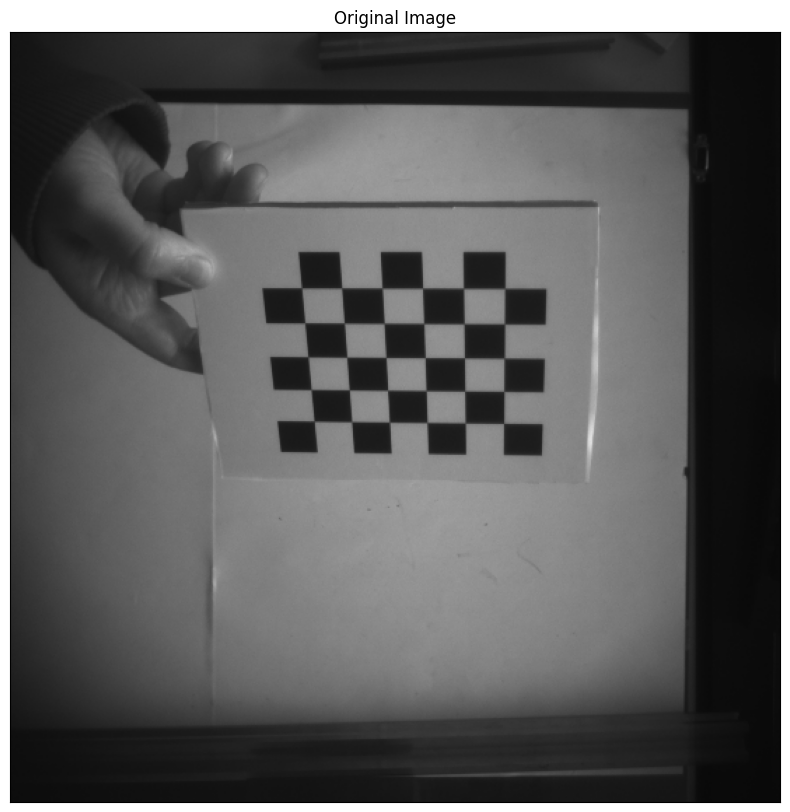

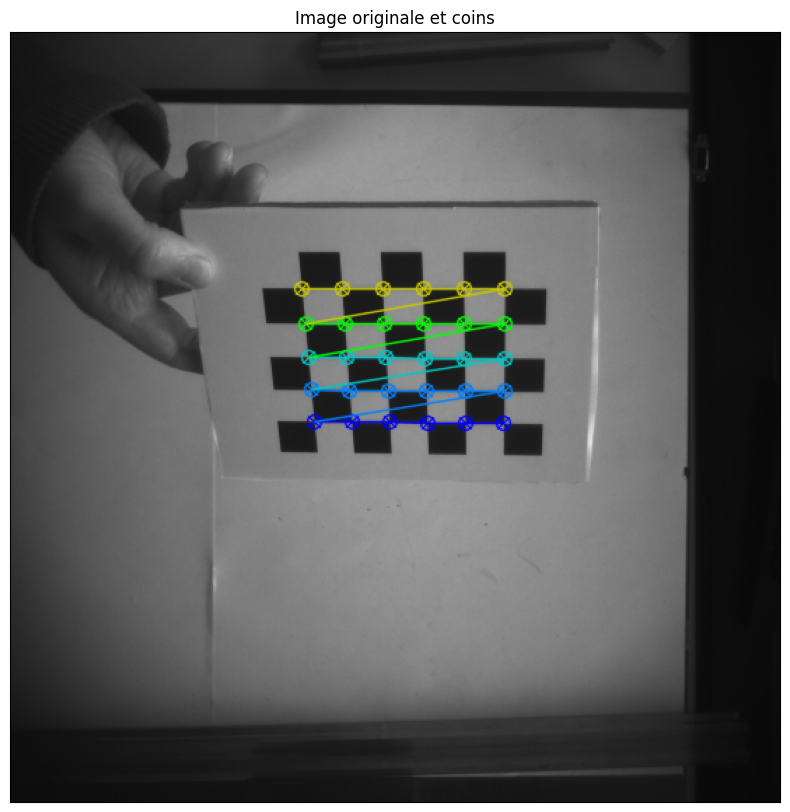

(<matplotlib.image.AxesImage at 0x7bc24845a950>,
 Text(0.5, 1.0, 'Image originale et coins'),
 ([], []),
 ([], []),
 None)

In [ ]:
# Les outils pour lire les images
import numpy as np
import glob
import matplotlib.pyplot  as plt
from skimage import io
import cv2
%matplotlib inline

FigSize=(10,10) #permet d'ajuster la tailles des images affichées

pattern = os.path.join(output_dir, '*NE.png')

#On extrait un tableau avec l'ensemble des fichiers images d'un dossier
images = glob.glob(pattern)
print(images)

# test: lire l'image n°2 de cette sequence
img = cv2.imread(images[1])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #conversion en NB si l'image est déclarée sur format RGB
fig, ax = plt.subplots(figsize=FigSize)
plt.imshow(img),plt.xticks([]), plt.yticks([]), plt.title('Original Image'), plt.show()

#pour détection les coins
ret, corners = cv2.findChessboardCorners(gray, (6,5),None)
cv2.drawChessboardCorners(img, (6,5), corners,ret)
fig, ax = plt.subplots(figsize=FigSize)
plt.imshow(img), plt.title('Image originale et coins'),plt.xticks([]), plt.yticks([]),plt.show()



<br/>**2. Calibrer une caméra**
<br/>La détermination des paramètres intrinsèques et extrinsèques avec OpenCV se base sur un article de référence : *"Zhang. A Flexible New Technique for Camera Calibration. IEEE Transactions on Pattern Analysis and Machine Intelligence, 22(11):1330-1334, 2000."*
<br>A partir de N vues d'un damier (16 minimum conseillées), la méthode détermine la matrice intrinsèque, mais aussi les paramètres extrinsèques pour chacune des vues. Chaque coin du damier qui est détecté sur une vue, doit se voir associer une coordonnée "objet" dans le repère monde, qui est pris sur le damier. L'orgine de ce repère sur le damier est arbitraire, mais on prend souvent (comme ci dessous), le premier coin détecté, comme origine (0,0). Les autres coins se voient alors associée une coordonnée métrique en fonction de la taille des carrés des damiers.
<br/>D'un point de vue algorithmique, la méthode se résume ainsi :
<br/>- Pour chaque image : détection des coins dans l'image et de leurs coordonnées "objets" correspondantes dans le repère monde pris sur le damier
<br/>- Calcul de la matrice intrinsèque et des paramètres extrinsèques pour chaque vue.

In [ ]:
# ON prepare les points object (ici en cm) :like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*5,3), np.float32)
objp[:,:2] = 3.0*np.mgrid[0:6,0:5].T.reshape(-1,2) #ici 3 cm x 3 cm pour la dimension des carrés

#print(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# critère pour optimisations dans les detections de coins
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # détection des coins
    ret, corners = cv2.findChessboardCorners(gray, (6,5),None)

    # Si coins trouvés, la détection est affinée pour précision sub-pixel
    if ret == True:
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria) # ne rien changer
        objpoints.append(objp) #pour chaque images, les points obj sont rassemblés dans 1 seule matrice
        imgpoints.append(corners) #idem avec les coins

# On calcule matrice intrinsèques et param. extrinsèques avec l'ensemble de ces correspondances
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

#Affichage de la matrice intrinsèque
print ('Matrice intrinsèque :')
print (mtx)
print('Estimation de la focale de l''objectif : ', mtx[0,0]*(7.5e-6)*1000,' mm (u)') # 7.5 micron = taille d'un pixel
print('Estimation de la focale de l''objectif : ', mtx[1,1]*(7.5e-6)*1000,' mm (v)') # 7.5 micron = taille d'un pixel


Matrice intrinsèque :
[[827.02060181   0.         288.10034908]
 [  0.         819.34836835 218.9627536 ]
 [  0.           0.           1.        ]]
Estimation de la focale de lobjectif :  6.202654513593223  mm (u)
Estimation de la focale de lobjectif :  6.14511276262296  mm (v)


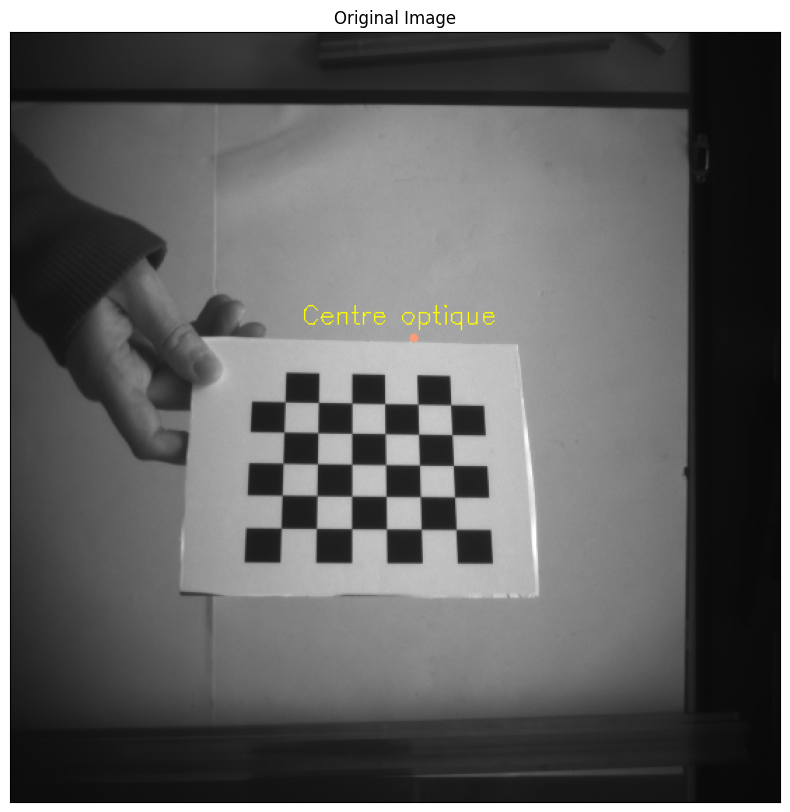

In [ ]:
# Affichage du centre optique sur la première image
InxdexIm = 3
img = cv2.imread(images[InxdexIm])
cv2.circle(img,(int(mtx[0,2]),int(mtx[1,2])), 3, (255,155,120), -1)
fig, ax = plt.subplots(figsize=FigSize)
cv2.putText(img, "Centre optique", (int(mtx[0,2])-80,int(mtx[1,2])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), lineType=3)
plt.imshow(img),plt.xticks([]), plt.yticks([]), plt.title('Original Image'),
plt.show()



<br/>**3. Vérifier sa calibration avec insertion d'objets en réalité augmentée**

In [ ]:
InxdexIm = 8
img = cv2.imread(images[InxdexIm])

# On peut aussi superposer une carré virtuel de 6cmx6cm sur l'image n°0
My3Dpoints = np.float32([[0,0,0],[0,6,0], [6,0,0], [6,6,0]]).reshape(-1,3)
imgpts3D, jac = cv2.projectPoints(My3Dpoints, rvecs[InxdexIm], tvecs[InxdexIm], mtx, dist)
cv2.circle(img, tuple(map(int, imgpts3D[0].ravel())), 3, (255, 0, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[1].ravel())), 3, (255, 255, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[2].ravel())), 3, (255, 255, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[3].ravel())), 3, (255, 0, 0), -1)

# Attention, ces cercles sont inscrutés dans l'image.

 #print imgpts3D
fig, ax = plt.subplots(figsize=FigSize)
plt.imshow(img),plt.xticks([]), plt.yticks([]), plt.title('Original Image'), plt.show()

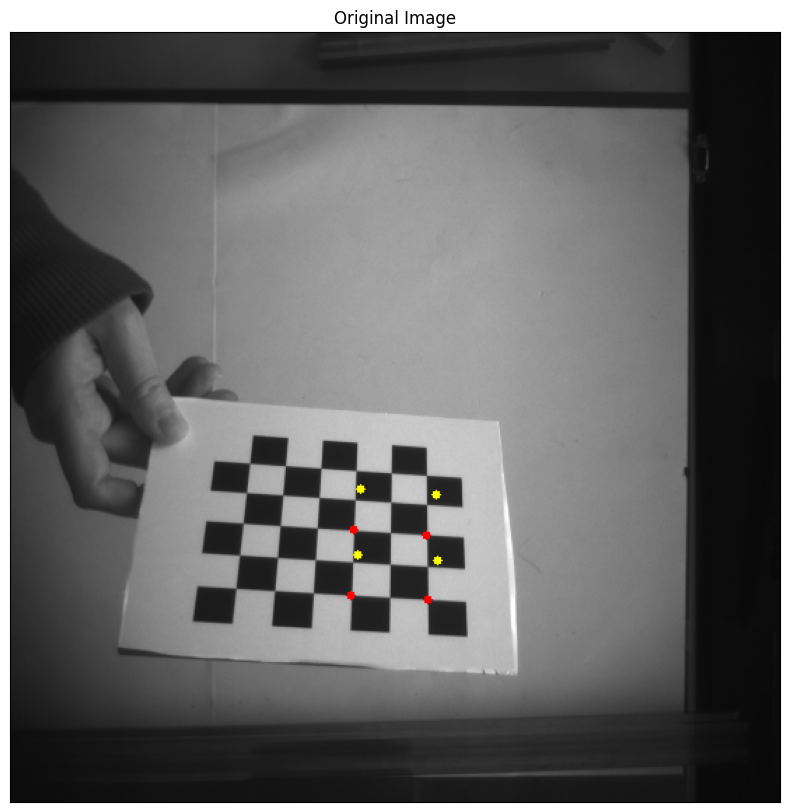

(<matplotlib.image.AxesImage at 0x7bc2482293f0>,
 ([], []),
 ([], []),
 Text(0.5, 1.0, 'Original Image'),
 None)

In [ ]:
# et donc sur n'importe quelle image calibrée : Tester plusieurs cas
IndexImage=15
img = cv2.imread(images[IndexImage])
My3Dpoints = np.float32([[0,0,0],[0,6,0], [6,0,0], [6,6,0],[0,0,-6],[0,6,-6], [6,0,-6], [6,6,-6]]).reshape(-1,3)
imgpts3D, jac = cv2.projectPoints(My3Dpoints, rvecs[IndexImage], tvecs[IndexImage], mtx, dist)
cv2.circle(img, tuple(map(int, imgpts3D[0].ravel())), 3, (255, 0, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[1].ravel())), 3, (255, 0, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[2].ravel())), 3, (255, 0, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[3].ravel())), 3, (255, 0, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[4].ravel())), 3, (255, 255, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[5].ravel())), 3, (255, 255, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[6].ravel())), 3, (255, 255, 0), -1)
cv2.circle(img, tuple(map(int, imgpts3D[7].ravel())), 3, (255, 255, 0), -1)

#print imgpts3D
fig, ax = plt.subplots(figsize=FigSize)
plt.imshow(img),plt.xticks([]), plt.yticks([]), plt.title('Original Image'), plt.show()

(<matplotlib.image.AxesImage at 0x7bc24822b1f0>,
 ([], []),
 ([], []),
 Text(0.5, 1.0, 'Original Image'))

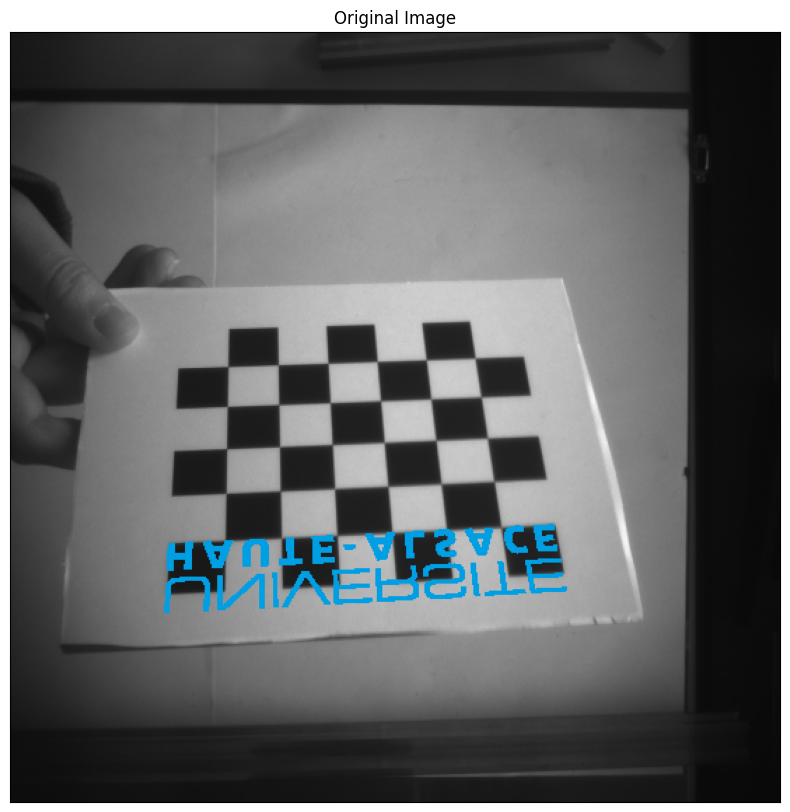

In [ ]:
IndexImage=12

# Étape 1 : Télécharger le fichier logo
logo_path = os.path.join(output_dir, 'log_UHA_nb_v1.png')
logo = cv2.imread(logo_path)  # Lire l'image du logo

img = cv2.imread(images[IndexImage])

coord=np.where(logo==0)
# On place la coordonnées (0,0) du logo en bas à droite du H
Y=coord[0]-np.max(coord[0])
X=np.min(coord[1])-coord[1]
scale=21.0/np.max(np.abs(X)) # le logo mesure 21 cm de long

#echelle en cm + décalage en cm (1 carreau=3 cm)
X=X*scale+18
Y=Y*scale # echelle en cm
Z=np.zeros_like(Y)

P3D=np.float32([X,Y,Z])
#P3D=np.float32([X,Z,Y])
# mise a plat en hauteur
#P3D=np.float32([X,Y+12,Z+3])

imgpts2D, jac = cv2.projectPoints(P3D.T, rvecs[IndexImage], tvecs[IndexImage], mtx, dist)

Xp=np.asarray(imgpts2D[:,0,0], dtype="uint32" )
Yp=np.asarray(imgpts2D[:,0,1], dtype="uint32" )

try:
    img[Yp,Xp]=(0,159,227)
except:
    print('Logo en dehors image')
    print(Xp, Yp)


#print imgpts3D
fig, ax = plt.subplots(figsize=FigSize)
plt.imshow(img),plt.xticks([]), plt.yticks([]), plt.title('Original Image')#, plt.show()


Le bon reposionnement du logo indique la qualité du calibrage

In [ ]:
print(coord)